In [6]:
!pip install -q accelerate==0.21.0 --progress-bar off
!pip install -q peft==0.4.0 --progress-bar off
!pip install -q bitsandbytes==0.40.2 --progress-bar off
!pip install -q transformers==4.31.0 --progress-bar off
!pip install -q trl==0.4.7 --progress-bar off

import os
from random import randrange
from functools import partial
import torch
from datasets import load_dataset
from transformers import (AutoModelForCausalLM,
                          AutoModelForSequenceClassification,
                          AutoTokenizer,
                          BitsAndBytesConfig,
                          HfArgumentParser,
                          Trainer,
                          TrainingArguments,
                          DataCollatorForLanguageModeling,
                          EarlyStoppingCallback,
                          pipeline,
                          logging,
                          set_seed)
import pandas as pd
from tqdm.notebook import tqdm

import bitsandbytes as bnb
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, PeftModel, AutoPeftModelForCausalLM
from trl import SFTTrainer

# Helper Function

In [2]:
import re
def remove_numbers(text):
    if isinstance(text, str):
        return re.sub(r'\d+', '', text)
    return text


def remove_year(string):
    return re.sub(r'\s20\d{2}(\s|\-\d{2})?', ' ', string)

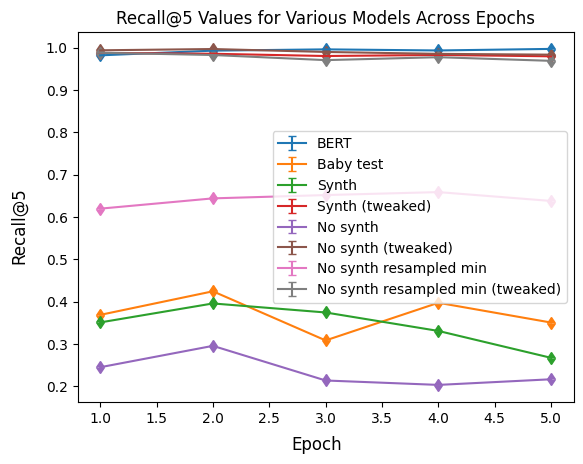

In [64]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
x = np.array([1, 2, 3, 4, 5])
y = np.array([0.3512, 0.3960, 0.3747, 0.3311, 0.2676])
y2 = np.array([0.2454, 0.2959, 0.2141, 0.2037, 0.2170])
#yerr = np.linspace(0.05, 0.2, 5)
y3 = np.array([0.3690, 0.4247, 0.3087, 0.3976, 0.3509])
y4 = np.array([0.9879, 0.9826, 0.9705, 0.9774, 0.9688])
y5 = np.array([0.6198, 0.6441, 0.6519, 0.6589, 0.6380])
y6 = np.array([0.9937, 0.9967, 0.9898, 0.9853, 0.9834])
y7 = np.array([0.9876, 0.9855, 0.9802, 0.9827, 0.9795])
y8 = np.array([0.9818, 0.9929, 0.9959, 0.9933, 0.9970])

yerr = 0

plt.title("Recall@5 Values for Various Models Across Epochs")

ax.errorbar(x, y8, yerr=yerr, uplims=True, lolims=True, label='BERT')

ax.errorbar(x, y3, yerr=yerr, uplims=True, lolims=True, label='Baby test')

ax.errorbar(x, y, yerr=yerr, uplims=True, lolims=True, label='Synth')

ax.errorbar(x, y7, yerr=yerr, uplims=True, lolims=True, label='Synth (tweaked)')

ax.errorbar(x, y2, yerr=yerr, uplims=True, lolims=True, label='No synth')

ax.errorbar(x, y6, yerr=yerr, uplims=True, lolims=True, label='No synth (tweaked)')

ax.errorbar(x, y5, yerr=yerr, uplims=True, lolims=True, label='No synth resampled min')

ax.errorbar(x, y4, yerr=yerr, uplims=True, lolims=True, label='No synth resampled min (tweaked)')

ax.legend(loc='center right')

ax.text(2.7, 0.05, 'Epoch', fontsize=12, color='black')
ax.text(0.2, 0.5, 'Recall@5', fontsize=12, color='black', rotation=90)

plt.show()

# Import Data

In [7]:
dataset = pd.read_csv('BIL Launchpad Case studies - Sheet1.csv')

"""
Cleaning the data:
- only include columns we will use: 'Project Name', 'Project Description', 'Applicants', 'opportunitytitle', 'description'
- drop column with missing information
- currently, the grant opportunities include years, i will omit this from their title to group recurring grants together
"""
dataset = dataset[['Project Name', 'Project Description', 'Applicants', 'opportunitytitle', 'description']]
clean_dataset = dataset.dropna()
print(len(clean_dataset['opportunitytitle'].unique()))
# print(dataset['opportunitytitle'].unique())
clean_dataset['description'] = clean_dataset['description'].apply(remove_numbers)
clean_dataset['opportunitytitle'] = clean_dataset['opportunitytitle'].apply(remove_numbers)

print(len(clean_dataset['opportunitytitle'].unique()))
# print(dataset['opportunitytitle'].unique())

79
55


<ipython-input-7-7d99546f415f>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_dataset['description'] = clean_dataset['description'].apply(remove_numbers)
<ipython-input-7-7d99546f415f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_dataset['opportunitytitle'] = clean_dataset['opportunitytitle'].apply(remove_numbers)


# Experiment 1: Classification of project <> grant name (multi-class text classification) (ignore description of program)

In [8]:
# Create new dataset of project + project name and grant title
simple_df = clean_dataset[['Project Name', 'Project Description', 'Applicants', 'opportunitytitle']]
simple_df['project_profile'] =  simple_df['Applicants'] + ': ' + simple_df['Project Description'] + ' ' + simple_df['Project Name']
simple_df = simple_df[['project_profile','opportunitytitle'] ]
possible_grants = simple_df['opportunitytitle'].unique()

#substitute label with number instead
label_dict = {}
for index, possible_label in enumerate(possible_grants):
    label_dict[possible_label] = index

simple_df['label'] = simple_df['opportunitytitle'].replace(label_dict)
simple_df.groupby(['opportunitytitle', 'label']).count()


,,project_profile
opportunitytitle,label,
Competitive Funding Opportunity: Pilot Program for Transit-Oriented Development (TOD) Planning,14,20
Tribal Transportation Program Safety Fund,8,175
*FY Notice of Funding Opportunity: Bipartisan Infrastructure Law (BIL) Airport Terminal Program (ATP) Grants,33,187
*FY Notice of Funding Opportunity: Bipartisan Infrastructure Law (BIL) FAA Contract Tower (FCT) Competitive Grant Program,36,53
*Grants for Buses and Bus Facilities Program,54,2
*INFRA Grants,12,20
Advanced Transportation Technologies and Innovative Mobility Deployment (ATTIMD) Program,17,8
"Bridge Investment Program - Planning, Bridge Projects, and Large Bridge Projects",19,37
FY Competitive Funding Opportunity: Public Transportation on Indian Reservations Program; Tribal Transit Program,15,39


In [9]:
simple_df['project_profile'][0]

'Fairbanks International Airport: This award funds the replacement of the passenger boarding bridge at Gate 3. Fairbanks International Airport'

# Experiment 2: Classification of project <> grant name (multi-class text classification) (with description of program)

In [10]:
def remove_year(string):
    return re.sub(r'\s20\d{2}(\s|\-\d{2})?', ' ', string)

In [11]:
dataset = pd.read_csv('BIL Launchpad Case studies - Sheet1.csv')

"""
Cleaning the data:
- only include columns we will use: 'Project Name', 'Project Description', 'Applicants', 'opportunitytitle', 'description'
- drop column with missing information
- currently, the grant opportunities include years, i will omit this from their title to group recurring grants together
"""
dataset = dataset[['Project Name', 'Project Description', 'Applicants', 'opportunitytitle', 'description']]
clean_dataset = dataset.dropna()
print(len(clean_dataset['opportunitytitle'].unique()))
# print(dataset['opportunitytitle'].unique())
clean_dataset['description'] = clean_dataset['description'].apply(remove_numbers)
clean_dataset['opportunitytitle'] = clean_dataset['opportunitytitle'].apply(remove_numbers)

print(len(clean_dataset['opportunitytitle'].unique()))
# print(dataset['opportunitytitle'].unique())

simple_df = clean_dataset
simple_df['project_profile'] =  simple_df['Applicants'] + ': ' + simple_df['Project Description'] + ' ' + simple_df['Project Name']
simple_df['grant_profile'] =  simple_df['opportunitytitle'] + ': ' + simple_df['description']
simple_df = simple_df[['project_profile','grant_profile'] ]
possible_grants = simple_df['grant_profile'].unique()

#substitute label with number instead
label_dict = {}
for index, possible_label in enumerate(possible_grants):
    label_dict[possible_label] = index

simple_df['label'] = simple_df['grant_profile'].replace(label_dict)
simple_df['grant_profile'].unique()[0]
simple_df.groupby(['grant_profile']) #.to_csv('file.csv')

79


<ipython-input-11-a322b54d1e08>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_dataset['description'] = clean_dataset['description'].apply(remove_numbers)
<ipython-input-11-a322b54d1e08>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_dataset['opportunitytitle'] = clean_dataset['opportunitytitle'].apply(remove_numbers)
<ipython-input-11-a322b54d1e08>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

55


<ipython-input-11-a322b54d1e08>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simple_df['label'] = simple_df['grant_profile'].replace(label_dict)


In [12]:
simple_df['project_profile'].unique()

array(['Fairbanks International Airport: This award funds the replacement of the passenger boarding bridge at Gate 3. Fairbanks International Airport',
       'Ted Stevens Anchorage International Airport: This award funds the installation of 110 audio and visual monitors/stations in the terminal to better serve the passengers. Ted Stevens Anchorage International Airport',
       'Ted Stevens Anchorage International Airport: This award funds the installation of a new passenger boarding bridge at gate B4. Ted Stevens Anchorage International Airport',
       ...,
       "Southeastern Pennsylvania Transportation Authority: The Southeastern Pennsylvania Transportation Authority (SEPTA) will receive funding to buy up to 200 new rail cars to replace older rail cars that have been in service for nearly 25 years, operating along the Market Frankford Line, the most heavily used line in SEPTA's system. buy up to 200 new rail cars to replace older rail cars",
       "Colorado Department of Transpo

# Train validation split

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(simple_df.index.values,
                                                  simple_df.label.values,
                                                  test_size=0.15,
                                                  random_state=42,
                                                  stratify=simple_df.label.values)

simple_df['data_type'] = ['not_set']*simple_df.shape[0]

simple_df.loc[X_train, 'data_type'] = 'train'
simple_df.loc[X_val, 'data_type'] = 'val'

simple_df.groupby(['grant_profile']).count()

<ipython-input-13-bf3db987913a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simple_df['data_type'] = ['not_set']*simple_df.shape[0]


,project_profile,label,data_type
grant_profile,,,
"Competitive Funding Opportunity: Pilot Program for Transit-Oriented Development (TOD) Planning: The Pilot Program for TOD Planning helps support FTA&#;s mission of improving public transportation for America&#;s communities by providing funding to local communities to integrate land use and transportation planning around a new fixed guideway or core capacity improvement project. Per statute, any comprehensive planning funded through the program must examine ways to improve economic development and ridership, foster multimodal connectivity and accessibility, improve transit access for pedestrian and bicycle traffic, engage the private sector, identify infrastructure needs, and enable mixed-use development near transit stations. Additional information is available at: https://www.transit.dot.gov/TODPilot.Notice of Funding Opportunity (NOFO): Notice of Funding Opportunity for PILOT PROGRAM FOR TRANSIT-ORIENTED DEVELOPMENT (TOD) PLANNING. The Federal Transit Administration (FTA) announces the opportunity to apply for $,, of funding under the Pilot Program for TOD Planning (Catalog of Federal Domestic Assistance #.). As required by federal transit law and subject to funding availability, funds will be awarded competitively to support comprehensive planning associated with new fixed guideway and core capacity improvement projects. FTA anticipates minimum grant awards of $, and maximum grant awards of $,,. Synopses and full announcement are posted on Grants.gov as opportunity FTA---TPE-TODP. The Pilot Program for TOD Planning is intended to fund comprehensive planning that supports economic development, ridership, multimodal connectivity and accessibility, increased transit access for pedestrian and bicycle traffic, and mixed-use development near transit stations. The program also encourages identification of infrastructure needs and engagement with the private sector.Consistent with statutory direction, FTA is seeking comprehensive planning projects covering an entire transit capital project corridor, rather than proposals that involve planning for individual station areas or only a small section of the corridor. To ensure any proposed planning work reflects the needs and aspirations of the local community and results in concrete, specific deliverables and outcomes, transit project sponsors must partner with entities with land use planning authority in the transit project corridor to conduct the planning work.Link and Instructions for attaching the supplemental form to the SF-: All applicants must complete a supplemental form (PDF) specific to the Pilot Program for TOD Planning and attach it to their submission in Grants.gov. See section D of the NOFO for information about additional required application contents.Webinar: FTA will conduct a webinar for prospective applicants after the NOFO is published in the Federal Register. Further information will be posted on FTA&#;s website (https://www.transit.dot.gov/TODPilot) when available. Dates: An applicant must submit a proposal electronically by : p.m. Eastern Daylight Time on June , . Any agency intending to apply should initiate the process of registering on the Grants.gov site immediately to ensure completion of registration before the submission deadline.",20,20,20
"Tribal Transportation Program Safety Fund: A Notice of Funding Availability (NOFA) for Tribal Transportation Program Safety Funds (TTPSF) has been published. This notice announces the availability of $. million for projects in three categories: safety plans; data assessment, improvement, and analysis activities; and infrastructure improvement and other eligible activities as listed in U.S.C.(a)() The deadline for submissions is //. For complete instructions on preparing and submitting an application for TTPSF, please download the application information and NOFO at https://flh.fhwa.dot.gov/programs/ttp/safety/ttpsf.htm Please submit your application directly to FHWA th

# Tokenisation

In [14]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: write).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in 

In [15]:
def create_bnb_config(load_in_4bit, bnb_4bit_use_double_quant, bnb_4bit_quant_type, bnb_4bit_compute_dtype):
    """
    Configures model quantization method using bitsandbytes to speed up training and inference

    :param load_in_4bit: Load model in 4-bit precision mode
    :param bnb_4bit_use_double_quant: Nested quantization for 4-bit model
    :param bnb_4bit_quant_type: Quantization data type for 4-bit model
    :param bnb_4bit_compute_dtype: Computation data type for 4-bit model
    """

    bnb_config = BitsAndBytesConfig(
        load_in_4bit = load_in_4bit,
        bnb_4bit_use_double_quant = bnb_4bit_use_double_quant,
        bnb_4bit_quant_type = bnb_4bit_quant_type,
        bnb_4bit_compute_dtype = bnb_4bit_compute_dtype,
    )

    return bnb_config

In [16]:
def load_model(model_name, bnb_config):
    """
    Loads model and model tokenizer

    :param model_name: Hugging Face model name
    :param bnb_config: Bitsandbytes configuration
    """

    # Get number of GPU device and set maximum memory
    n_gpus = torch.cuda.device_count()
    max_memory = f'{40960}MB'

    # Load model
    #model = AutoModelForCausalLM.from_pretrained(
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        config = bnb_config,
        #device_map = "auto", # dispatch the model efficiently on the available resources
        #max_memory = {i: max_memory for i in range(n_gpus)},
    )
    print(model.model_name)

    # Load model tokenizer with the user authentication token
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token = True)

    # Set padding token as EOS token
    tokenizer.pad_token = tokenizer.eos_token

    return model, tokenizer

In [17]:
################################################################################
# transformers parameters
################################################################################

# The pre-trained model from the Hugging Face Hub to load and fine-tune
model_name = "meta-llama/Llama-2-7b-hf"

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
load_in_4bit = True

# Activate nested quantization for 4-bit base models (double quantization)
bnb_4bit_use_double_quant = True

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Compute data type for 4-bit base models
bnb_4bit_compute_dtype = torch.bfloat16

In [ ]:
# Load model from Hugging Face Hub with model name and bitsandbytes configuration

bnb_config = create_bnb_config(load_in_4bit, bnb_4bit_use_double_quant, bnb_4bit_quant_type, bnb_4bit_compute_dtype)

model, tokenizer = load_model(model_name, bnb_config)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

# Llama 2

In [ ]:
print(model)
print(tokenizer)

NameError: name 'model' is not defined

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 3

dataloader_train = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val,
                                   sampler=SequentialSampler(dataset_val),
                                   batch_size=batch_size)

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5,
                  eps=1e-8)

epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

/Users/bhumikornkongtaveelert/miniconda3/envs/cs224n/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from sklearn.metrics import f1_score
import numpy as np

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels, label_dict):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    class_accuracies = {}
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat == label]
        y_true = labels_flat[labels_flat == label]
        accuracy = len(y_preds[y_preds == label]) / len(y_true)
        class_accuracies[label_dict_inverse[label]] = accuracy
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds == label])}/{len(y_true)} ({accuracy:.4f})\n')

    return class_accuracies

def recall_at_k(y_true, y_pred, k=5):
    num_samples = len(y_true)
    recall_count = 0

    for true_label, predictions in zip(y_true, y_pred):
        top_k_predictions = np.argsort(predictions)[-k:]  # Get indices of the top k predictions
        if true_label in top_k_predictions:
            recall_count += 1

    recall_at_k_score = recall_count / num_samples
    return recall_at_k_score

def evaluate(dataloader_val):
    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total / len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    recall_at_5 = recall_at_k(true_vals, predictions, k=5)

    return loss_val_avg, predictions, true_vals, recall_at_5


In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
device = 'cpu'
# !pip install ipywidgets
# ! pip install jupyter
# ! pip install ipywidgets widgetsnbextension pandas-profiling
# ! pip install jupyter_contrib_nbextensions
# ! jupyter contrib nbextension install --user
# !jupyter nbextension enable --py widgetsnbextension
for epoch in tqdm(range(1, epochs+1)):

    model.train()

    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

    torch.save(model.state_dict(), f'data_volume/finetuned_BERT_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    loss_val_avg, predictions, true_vals, recall_at_5 = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {loss_val_avg}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    tqdm.write(f'Recall@5: {recall_at_5}')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1271 [00:00<?, ?it/s]


Epoch 1
Training loss: 2.3909019886286687
Validation loss: 1.5648361675441265
F1 Score (Weighted): 0.5774398178794486
Recall@5: 0.8826151560178306


Epoch 2:   0%|          | 0/1271 [00:00<?, ?it/s]


Epoch 2
Training loss: 1.287690200938174
Validation loss: 1.046124068022602
F1 Score (Weighted): 0.6552218122748082
Recall@5: 0.9479940564635958


Epoch 3:   0%|          | 0/1271 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Evaluate

# Predict

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)
device = 'cpu'
model.to(device)

model.load_state_dict(torch.load('data_volume/finetuned_BERT_epoch_2.model', map_location=torch.device('cpu')))
# Example input texts
input_texts = ["This is the first example sentence.", "This is the second example sentence."]

# Tokenize the input texts
inputs = tokenizer(input_texts, return_tensors='pt', truncation=True, padding=True, max_length=512)
inputs = {key: value.to(device) for key, value in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
probabilities = torch.nn.functional.softmax(logits, dim=-1)
predicted_classes = torch.argmax(probabilities, dim=1).cpu().numpy()
# Print the predicted classes
for text, predicted_class in zip(input_texts, predicted_classes):
    print(f'Text: "{text}" - Predicted class: {predicted_class}')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Text: "This is the first example sentence." - Predicted class: 8
Text: "This is the second example sentence." - Predicted class: 8


In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load model and tokenizer
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)
model.load_state_dict(torch.load('data_volume/finetuned_BERT_epoch_1.model', map_location=device))
model.to(device)
model.eval()

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Example input texts
input_texts = ['Fairbanks International Airport: This award funds the replacement of the passenger boarding bridge at Gate 3. Fairbanks International Airport',
       'Ted Stevens Anchorage International Airport: This award funds the installation of 110 audio and visual monitors/stations in the terminal to better serve the passengers. Ted Stevens Anchorage International Airport',
       'Ted Stevens Anchorage International Airport: This award funds the installation of a new passenger boarding bridge at gate B4. Ted Stevens Anchorage International Airport',
       "Southeastern Pennsylvania Transportation Authority: The Southeastern Pennsylvania Transportation Authority (SEPTA) will receive funding to buy up to 200 new rail cars to replace older rail cars that have been in service for nearly 25 years, operating along the Market Frankford Line, the most heavily used line in SEPTA's system. buy up to 200 new rail cars to replace older rail cars",
       "Colorado Department of Transportation: The Colorado Department of Transportation, on behalf of Summit Stage, a rural transit agency serving Summit, Park and Lake counties, will receive funding to build a new charging and operation bus facility, which will include 100% electrification, fleet storage, and electric vehicle charging. The new facility will replace Summit Stage's current aging facility. Colorado Department of Transportation_CO_Buses and Bus Facilities Competitive Program",
       'Bi-State Development Agency: The Bi-State Development Agency of St. Louis will receive funding to transform bus stops into mobility hubs to improve safety and create a more welcoming experience for riders. The hubs will improve accessibility and include amenities such as benches, lighting and community information, at key transit transfer points. The BiState Development Agency of St Louis to transform bus stops into mobility hubs to improve safety and create a more welcoming experience for ride_MO']

# Tokenize and prepare input data
inputs = tokenizer(input_texts, return_tensors='pt', truncation=True, padding=True, max_length=512)
inputs = {key: value.to(device) for key, value in inputs.items()}

# Make predictions
with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
probabilities = torch.nn.functional.softmax(logits, dim=-1)

# Extract top 5 predicted classes and their probabilities
top_k = 5
top_k_probabilities, top_k_indices = torch.topk(probabilities, top_k, dim=1)
top_k_probabilities = top_k_probabilities.cpu().numpy()
top_k_indices = top_k_indices.cpu().numpy()

# Print the top 5 predicted classes and their probabilities for each input text
for text, indices, probs in zip(input_texts, top_k_indices, top_k_probabilities):
    print(f'Text: "{text}"')
    for idx, (pred_idx, prob) in enumerate(zip(indices, probs)):
        print(f'  Top {idx + 1}: {reversed_label_dict[pred_idx]} (Probability: {prob:.4f})')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Text: "Fairbanks International Airport: This award funds the replacement of the passenger boarding bridge at Gate 3. Fairbanks International Airport"
  Top 1: FY  Notice of Funding Opportunity: Bipartisan Infrastructure Law (BIL) Airport Terminal Program (ATP) Grants: The Department of Transportation (DOT), Federal Aviation Administration (FAA) announces the opportunity to apply for approximately $ billion in FY  discretionary funds for the Airport Terminal Program (ATP), made available under the Infrastructure Investment and Jobs Act of  (IIJA), Pub. L. -, herein referred to as the Bipartisan Infrastructure Law (BIL). The purpose of the ATP is to make annual grants available to eligible airports for airport terminal and airport-owned Airport Traffic Control Towers development projects that address the aging infrastructure of our nation&#;s airports. In addition, ATP grants will align with DOT&#;s Strategic Framework FY- at https://www.transportation.gov/administrations/office-policy/f

In [ ]:
reversed_label_dict = {v: k for k, v in label_dict.items()}

# Print the reversed dictionary
print(reversed_label_dict)

{0: 'FY  Notice of Funding Opportunity: Bipartisan Infrastructure Law (BIL) Airport Terminal Program (ATP) Grants: The Department of Transportation (DOT), Federal Aviation Administration (FAA) announces the opportunity to apply for approximately $ billion in FY  discretionary funds for the Airport Terminal Program (ATP), made available under the Infrastructure Investment and Jobs Act of  (IIJA), Pub. L. -, herein referred to as the Bipartisan Infrastructure Law (BIL). The purpose of the ATP is to make annual grants available to eligible airports for airport terminal and airport-owned Airport Traffic Control Towers development projects that address the aging infrastructure of our nation&#;s airports. In addition, ATP grants will align with DOT&#;s Strategic Framework FY- at https://www.transportation.gov/administrations/office-policy/fy--strategic-framework. The FY  ATP will be implemented consistent with law and in alignment with the priorities in Executive Order , Implementation of th